## Importing all necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import h5py as hd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import set_config
set_config(display="diagram")
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from random import shuffle, seed
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
import time

## Exploratory Data Analysis (EDA)

The data is from a Data Acquisition of an Automobile Vehicle. The data is usually collected by events. An event can be a particular type of road or maneuver with same or different speeds, accelerations, brakings. The road can be a belgian block road, a road with potholes, cobblestone, speed bumps...

The goal is to mimic all possible usage of a vehicle including abuse use. These loads are used to calculate the loads on all the components thus to assess the durability of the part. Most important are the fatigue and strenght of the parts.

The data collected has 60 features in three different files with different rates: 500Hz, 1000Hz and 2500Hz. The 500Hz and 1000Hz data are resampled at 2500Hz in other to have coherent data. All three are finally merged together.

The accelerations are in g, the forces in Newton, the time in seconds and the displacement in millimeters.

Not all the features are unsed for the study.

Let jump to the variable:

```
Some input variable (not all):

- Front Left Damper displacement(mm): J4543_WFT@LtFrDampDisp.RN_1
- Front Right Damper displacement(mm): J4543_WFT@RtFrDampDisp.RN_1
- Rear Left Damper displacement(mm): J4543_WFT@LtRrDampDisp.RN_1
- Rear Right Damper displacement(mm): J4543_WFT@RtRrDampDisp.RN_1

- Front Left Knuckle Acceleration in Z (g): J4543_2500@LtFrKnklAccZ.RN_1
- Front Right Knuckle Acceleration in Z (g): J4543_2500@RtFrKnklAccZ.RN_1
- Rear Left Knuckle Acceleration in Z (g): J4543_2500@LtRrKnklAccZ.RN_1
- Rear Right Knuckle Acceleration in Z (g): J4543_2500@RtRrKnklAccZ.RN_1

Output variable (desired target):

- Front Left FX force (N): J4543_WFT@LF_WFT_FX.RN_1
- Front Left FY force (N): J4543_WFT@LF_WFT_FY.RN_1
- Front Left FZ force (N): J4543_WFT@LF_WFT_FZ.RN_1
- Front Left MX moment (Nm): J4543_WFT@LF_WFT_MX.RN_1
- Front Left MY moment (Nm): J4543_WFT@LF_WFT_MY.RN_1
- Front Left MZ moment (Nm): J4543_WFT@LF_WFT_MZ.RN_1

- Front Right FX force (N): J4543_WFT@RF_WFT_FX.RN_1
- Front Right FY force (N): J4543_WFT@RF_WFT_FY.RN_1
- Front Right FZ force (N): J4543_WFT@RF_WFT_FZ.RN_1
- Front Right MX moment (Nm): J4543_WFT@RF_WFT_MX.RN_1
- Front Right MY moment (Nm): J4543_WFT@RF_WFT_MY.RN_1
- Front Right MZ moment (Nm): J4543_WFT@RF_WFT_MZ.RN_1

- Rear Left FX force (N): J4543_WFT@LR_WFT_FX.RN_1
- Rear Left FY force (N): J4543_WFT@LR_WFT_FY.RN_1
- Rear Left FZ force (N): J4543_WFT@LR_WFT_FZ.RN_1
- Rear Left MX moment (Nm): J4543_WFT@LR_WFT_MX.RN_1
- Rear Left MY moment (Nm): J4543_WFT@LR_WFT_MY.RN_1
- Rear Left MZ moment (Nm): J4543_WFT@LR_WFT_MZ.RN_1

- Rear Right FX force (N): J4543_WFT@RR_WFT_FX.RN_1
- Rear Right FY force (N): J4543_WFT@RR_WFT_FY.RN_1
- Rear Right FZ force (N): J4543_WFT@RR_WFT_FZ.RN_1
- Rear Right MX moment (Nm): J4543_WFT@RR_WFT_MX.RN_1
- Rear Right MY moment (Nm): J4543_WFT@RR_WFT_MY.RN_1
- Rear Right MZ moment (Nm): J4543_WFT@RR_WFT_MZ.RN_1


```

The loads at the spindle are important because, the loads to a vehicle come mostly from the wheels. Whith these loads, the other can be cascated with simulation. The forces on the body are high or low depending on the caracteristics of the damper assembly (damper and spring).

For this study, only the front left FZ will be predicted.

### Data input

In [2]:
# The data is loaded in three different files
ab10_500Hz=pd.read_csv('GVW_Chatter_Bumps_25mph_J4543ab_10_500Hz_x_lr.csv', skiprows=[0,1,3,4,5,6,7])
ab10_500Hz=ab10_500Hz.drop(ab10_500Hz.columns[0],axis=1).rename(columns={" .1": "time (s)"})
ab10_1000Hz=pd.read_csv('GVW_Chatter_Bumps_25mph_J4543ab_10_1000Hz_x_lr.csv', skiprows=[0,1,3,4,5,6,7])
ab10_1000Hz=ab10_1000Hz.drop(ab10_1000Hz.columns[0],axis=1).rename(columns={" .1": "time (s)"})
ab10_2500Hz=pd.read_csv('GVW_Chatter_Bumps_25mph_J4543ab_10_2500Hz_x_lr.csv', skiprows=[0,1,3,4,5,6,7])
ab10_2500Hz=ab10_2500Hz.drop(ab10_2500Hz.columns[0],axis=1).rename(columns={" .1": "time (s)"})

### 500Hz data

In [3]:
ab10_500Hz

,time (s),J4543_CAN@vehicleSp002.RN_1,J4543_CAN@latAccelA1_S.RN_1,J4543_CAN@longAccelA2_.RN_1,J4543_CAN@pitchRate_SR.RN_1,J4543_CAN@rollRate_SRS.RN_1,J4543_CAN@yawratePSIP1.RN_1,J4543_CAN@zAccelAZ1_SR.RN_1
0,0.0000,0.00000,0.091267,0.093753,0.019995,-0.010268,0.030019,-0.026178
1,0.0004,0.00000,0.093019,0.097741,0.019995,-0.010268,0.030019,-0.026178
2,0.0008,0.00000,0.094771,0.101728,0.019995,-0.010268,0.030019,-0.026178
3,0.0012,0.00000,0.096524,0.105716,0.019995,-0.010268,0.030019,-0.026178
4,0.0016,0.00000,0.098276,0.109703,0.019995,-0.010268,0.030019,-0.026178
...,...,...,...,...,...,...,...,...
148471,59.3884,30.53938,-0.091267,-1.996235,1.439926,1.419673,-0.140038,0.094999
148472,59.3888,30.53938,-0.091267,-1.996235,1.439926,1.419673,-0.140038,0.094999
148473,59.3892,30.53938,-0.091267,-1.996235,1.439926,1.419673,-0.140038,0.094999
148474,59.3896,30.53938,-0.091267,-1.996235,1.439926,1.419673,-0.140038,0.094999


In [4]:
ab10_500Hz.describe()

,time (s),J4543_CAN@vehicleSp002.RN_1,J4543_CAN@latAccelA1_S.RN_1,J4543_CAN@longAccelA2_.RN_1,J4543_CAN@pitchRate_SR.RN_1,J4543_CAN@rollRate_SRS.RN_1,J4543_CAN@yawratePSIP1.RN_1,J4543_CAN@zAccelAZ1_SR.RN_1
count,148476.000000,148476.000000,148476.000000,148476.000000,148476.000000,148476.000000,148476.000000,148476.000000
mean,29.695000,35.904617,0.077632,0.174102,0.060591,0.043018,0.234268,-0.050209
std,17.144589,7.916992,0.357258,1.069869,2.669066,3.331932,0.597017,1.227321
min,0.000000,0.000000,-2.175000,-3.888749,-8.319911,-22.430010,-2.454961,-5.111320
25%,14.847500,37.459990,-0.077527,-0.176233,-1.439926,-1.154254,-0.140038,-0.536240
50%,29.695000,38.409800,0.086222,0.083785,0.029993,0.019851,0.207984,-0.046264
75%,44.542500,38.859650,0.248776,0.531309,1.529904,1.310151,0.620037,0.454298
max,59.390000,41.058750,1.833762,3.798793,9.099720,19.119720,2.554922,5.394834


### 1000Hz data

In [5]:
ab10_1000Hz

,time (s),J4543_WFT@LtFrDampDisp.RN_1,J4543_WFT@RtFrDampDisp.RN_1,J4543_WFT@LtRrDampDisp.RN_1,J4543_WFT@RtRrDampDisp.RN_1,J4543_WFT@LF_WFT_FX.RN_1,J4543_WFT@LF_WFT_FY.RN_1,J4543_WFT@LF_WFT_FZ.RN_1,J4543_WFT@LF_WFT_MX.RN_1,J4543_WFT@LF_WFT_MY.RN_1,...,J4543_WFT@LR_WFT_FZ.RN_1,J4543_WFT@LR_WFT_MX.RN_1,J4543_WFT@LR_WFT_MY.RN_1,J4543_WFT@LR_WFT_MZ.RN_1,J4543_WFT@RR_WFT_FX.RN_1,J4543_WFT@RR_WFT_FY.RN_1,J4543_WFT@RR_WFT_FZ.RN_1,J4543_WFT@RR_WFT_MX.RN_1,J4543_WFT@RR_WFT_MY.RN_1,J4543_WFT@RR_WFT_MZ.RN_1
0,0.0000,57.34196,59.90269,76.96607,76.44981,-60.09464,-81.20045,7697.875,725.4261,44.38094,...,7901.947,881.1889,-70.34964,15.62687,-205.4747,77.46227,8809.615,-985.9553,-78.95902,-27.01127
1,0.0004,57.33297,59.91190,76.95621,76.44981,-59.37923,-81.20045,7697.875,725.4261,44.26165,...,7901.947,881.1889,-70.34964,15.49755,-205.4747,77.84637,8809.615,-985.8370,-79.08428,-27.01127
2,0.0008,57.32397,59.92112,76.94636,76.44981,-58.66382,-81.20045,7697.875,725.4261,44.14236,...,7901.947,881.1889,-70.34964,15.36822,-205.4747,78.23048,8809.615,-985.7188,-79.20954,-27.01127
3,0.0012,57.31562,59.92572,76.94636,76.44981,-58.30611,-81.20045,7698.181,725.4261,44.08271,...,7901.556,881.1889,-70.34964,15.36822,-205.4747,78.23048,8809.950,-985.7188,-79.20954,-27.01127
4,0.0016,57.30791,59.92572,76.95621,76.44981,-58.30611,-81.20045,7698.793,725.4261,44.08271,...,7900.774,881.1889,-70.34964,15.49755,-205.4747,77.84637,8810.620,-985.8370,-79.08428,-27.01127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145913,58.3652,68.92982,71.92206,75.08544,64.54243,2084.89100,397.66140,8064.197,996.0730,-793.67860,...,7826.239,962.8017,-388.91070,-117.21230,866.3890,674.91400,7481.221,-750.9111,-385.66900,146.75130
145914,58.3656,68.92982,71.92206,75.08544,64.54243,2084.89100,397.66140,8064.197,996.0730,-793.67860,...,7826.239,962.8017,-388.91070,-117.21230,866.3890,674.91400,7481.221,-750.9111,-385.66900,146.75130
145915,58.3660,68.92982,71.92206,75.08544,64.54243,2084.89100,397.66140,8064.197,996.0730,-793.67860,...,7826.239,962.8017,-388.91070,-117.21230,866.3890,674.91400,7481.221,-750.9111,-385.66900,146.75130
145916,58.3664,68.92982,71.92206,75.08544,64.54243,2084.89100,397.66140,8064.197,996.0730,-793.67860,...,7826.239,962.8017,-388.91070,-117.21230,866.3890,674.91400,7481.221,-750.9111,-385.66900,146.75130


In [6]:
ab10_1000Hz.describe()

,time (s),J4543_WFT@LtFrDampDisp.RN_1,J4543_WFT@RtFrDampDisp.RN_1,J4543_WFT@LtRrDampDisp.RN_1,J4543_WFT@RtRrDampDisp.RN_1,J4543_WFT@LF_WFT_FX.RN_1,J4543_WFT@LF_WFT_FY.RN_1,J4543_WFT@LF_WFT_FZ.RN_1,J4543_WFT@LF_WFT_MX.RN_1,J4543_WFT@LF_WFT_MY.RN_1,...,J4543_WFT@LR_WFT_FZ.RN_1,J4543_WFT@LR_WFT_MX.RN_1,J4543_WFT@LR_WFT_MY.RN_1,J4543_WFT@LR_WFT_MZ.RN_1,J4543_WFT@RR_WFT_FX.RN_1,J4543_WFT@RR_WFT_FY.RN_1,J4543_WFT@RR_WFT_FZ.RN_1,J4543_WFT@RR_WFT_MX.RN_1,J4543_WFT@RR_WFT_MY.RN_1,J4543_WFT@RR_WFT_MZ.RN_1
count,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,...,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000,145918.000000
mean,29.183400,57.487540,61.648528,80.492330,78.958851,-72.695207,-19.913753,7477.182409,808.554412,71.805736,...,8097.466286,900.434801,132.545435,33.069873,-399.332971,525.661808,8632.192650,-912.704262,107.434104,-1.831643
std,16.849217,10.426925,9.748836,10.313065,10.750141,886.527982,571.220726,1757.622708,257.622017,237.583465,...,1698.987067,288.918339,306.136287,138.306155,1036.383521,794.471079,1802.923326,287.494080,308.848895,143.650857
min,0.000000,23.753840,30.421850,40.343130,41.697400,-3085.931000,-4015.743000,1069.478000,-943.404400,-861.781800,...,1853.621000,-571.786100,-755.666800,-706.291600,-4310.286000,-2828.685000,1361.897000,-1938.079000,-764.028100,-560.184000
25%,14.591700,53.215550,57.672550,74.560680,72.692690,-399.012350,-204.522075,6863.701000,717.421925,36.833190,...,7461.083000,760.463100,-2.257889,-19.674770,-663.168200,106.078500,7893.531000,-1058.509000,-27.333690,-40.197810
50%,29.183400,57.319480,61.312240,79.609210,77.800330,-117.900000,26.347220,7466.653000,815.918900,62.680950,...,8036.365000,913.534850,45.800970,20.730930,-231.320000,388.607700,8639.531000,-936.923700,19.952250,13.060390
75%,43.775100,62.825640,66.731157,85.781200,84.358025,122.979400,266.465100,8064.197000,931.231800,105.597900,...,8707.185750,1034.063000,158.056700,72.753343,10.010310,757.849875,9369.674000,-791.260200,131.720600,54.022530
max,58.366800,105.238300,107.809100,134.546900,128.641300,5851.573000,3029.611000,16717.670000,1943.159000,888.350700,...,16004.640000,2083.100000,1463.532000,621.540100,4794.439000,5244.227000,18291.860000,689.813800,1465.810000,972.613300


### 2500Hz data

In [7]:
ab10_2500Hz

,time (s),J4543_2500@LtFrKnklAccX.RN_1,J4543_2500@LtFrKnklAccY.RN_1,J4543_2500@LtFrKnklAccZ.RN_1,J4543_2500@RtFrKnklAccX.RN_1,J4543_2500@RtFrKnklAccY.RN_1,J4543_2500@RtFrKnklAccZ.RN_1,J4543_2500@LtRrKnklAccX.RN_1,J4543_2500@LtRrKnklAccY.RN_1,J4543_2500@LtRrKnklAccZ.RN_1,...,J4543_2500@Bat_LtFrAccZ.RN_1,J4543_2500@Bat_RtFrAccX.RN_1,J4543_2500@Bat_RtFrAccY.RN_1,J4543_2500@Bat_RtFrAccZ.RN_1,J4543_2500@Bat_LtRrAccX.RN_1,J4543_2500@Bat_LtRrAccY.RN_1,J4543_2500@Bat_LtRrAccZ.RN_1,J4543_2500@Bat_RtRrAccX.RN_1,J4543_2500@Bat_RtRrAccY.RN_1,J4543_2500@Bat_RtRrAccZ.RN_1
0,0.0000,0.003894,0.300465,0.031762,-0.011676,-0.268307,0.033993,0.153509,-0.340660,-0.060253,...,-0.090042,0.048548,-0.283791,0.032558,0.022504,-0.294240,-0.016659,0.015584,-0.294280,-0.044968
1,0.0004,0.000000,0.314772,0.038115,0.000000,-0.271223,0.033993,0.074279,-0.344645,-0.072304,...,-0.109337,0.048548,-0.283791,0.003618,0.014744,-0.282954,-0.016659,0.004212,-0.286720,-0.016188
2,0.0008,0.003894,0.307618,0.038115,0.003892,-0.268307,0.028328,0.113894,-0.344645,-0.072304,...,-0.052096,0.033201,-0.283791,0.003618,0.014744,-0.290210,-0.025915,0.004212,-0.294280,-0.007195
3,0.0012,-0.003894,0.307618,0.038115,-0.003892,-0.256641,0.028328,0.118846,-0.350621,-0.078329,...,-0.042449,0.044790,-0.295245,0.013265,0.022504,-0.290210,-0.007404,0.004212,-0.298330,-0.035375
4,0.0016,0.003894,0.319542,0.019057,-0.011676,-0.256641,0.033993,0.123798,-0.346637,-0.078329,...,-0.061743,0.048548,-0.295245,0.032558,0.026384,-0.286985,-0.007404,0.011793,-0.282941,-0.035375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144379,57.7516,0.424465,-1.430783,-4.414956,4.378585,-0.918660,0.385255,2.986001,0.137459,4.904618,...,0.156288,1.682907,0.046052,0.060896,1.660647,-0.121727,0.134201,1.631472,-0.248383,-0.661330
144380,57.7520,0.424465,-1.430783,-4.414956,4.378585,-0.918660,0.385255,2.986001,0.137459,4.904618,...,0.156288,1.682907,0.046052,0.060896,1.660647,-0.121727,0.134201,1.631472,-0.248383,-0.661330
144381,57.7524,0.424465,-1.430783,-4.414956,4.378585,-0.918660,0.385255,2.986001,0.137459,4.904618,...,0.156288,1.682907,0.046052,0.060896,1.660647,-0.121727,0.134201,1.631472,-0.248383,-0.661330
144382,57.7528,0.424465,-1.430783,-4.414956,4.378585,-0.918660,0.385255,2.986001,0.137459,4.904618,...,0.156288,1.682907,0.046052,0.060896,1.660647,-0.121727,0.134201,1.631472,-0.248383,-0.661330


In [8]:
ab10_2500Hz.describe()

,time (s),J4543_2500@LtFrKnklAccX.RN_1,J4543_2500@LtFrKnklAccY.RN_1,J4543_2500@LtFrKnklAccZ.RN_1,J4543_2500@RtFrKnklAccX.RN_1,J4543_2500@RtFrKnklAccY.RN_1,J4543_2500@RtFrKnklAccZ.RN_1,J4543_2500@LtRrKnklAccX.RN_1,J4543_2500@LtRrKnklAccY.RN_1,J4543_2500@LtRrKnklAccZ.RN_1,...,J4543_2500@Bat_LtFrAccZ.RN_1,J4543_2500@Bat_RtFrAccX.RN_1,J4543_2500@Bat_RtFrAccY.RN_1,J4543_2500@Bat_RtFrAccZ.RN_1,J4543_2500@Bat_LtRrAccX.RN_1,J4543_2500@Bat_LtRrAccY.RN_1,J4543_2500@Bat_LtRrAccZ.RN_1,J4543_2500@Bat_RtRrAccX.RN_1,J4543_2500@Bat_RtRrAccY.RN_1,J4543_2500@Bat_RtRrAccZ.RN_1
count,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,...,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000,144384.000000
mean,28.876600,-0.065748,0.194418,-0.007318,-0.107053,-0.313926,0.041418,-0.351105,-0.205576,-0.084900,...,-0.098852,-0.107474,-0.265307,0.034607,-0.140240,-0.255438,-0.001958,-0.150044,-0.255100,-0.016251
std,16.672086,13.101865,7.799967,36.768490,12.726902,7.066690,32.537723,17.380690,6.700692,39.335148,...,2.199449,1.322723,0.960224,2.098667,1.313953,0.962049,1.942003,1.267328,1.015664,2.072931
min,0.000000,-127.604500,-56.735330,-163.105600,-127.535500,-58.292600,-163.331000,-162.264200,-65.279270,-175.903500,...,-21.075060,-10.263450,-7.660018,-19.756980,-24.572140,-21.202220,-28.516260,-6.658350,-8.791141,-19.646830
25%,14.438300,-2.722031,-1.430783,-4.592825,-2.642720,-1.723581,-4.317118,-3.778306,-1.763066,-5.748164,...,-0.801377,-0.596049,-0.582777,-0.654185,-0.647187,-0.570745,-0.716354,-0.629044,-0.574521,-0.794435
50%,28.876600,-0.120720,0.238464,-0.019057,-0.190712,-0.282889,0.028328,-0.153509,-0.320739,-0.072304,...,-0.109337,0.006264,-0.279817,0.042205,-0.031816,-0.267638,0.011106,-0.045699,-0.255943,-0.025782
75%,43.314900,2.570158,1.614401,5.247128,2.315785,1.011984,5.336909,3.505952,1.280962,6.760419,...,0.621293,0.359258,0.046052,0.824213,0.325921,0.054817,0.720982,0.315049,0.058586,0.761459
max,57.753200,93.343470,78.137470,208.150900,93.834060,95.561020,185.641700,111.467500,47.664540,197.432000,...,19.633100,9.359509,7.284358,15.940400,25.427290,26.414700,30.326580,6.900534,8.846487,13.209810


### Distribution of the front left knuckle accelerations in Z direction

The mean value is allmost zero

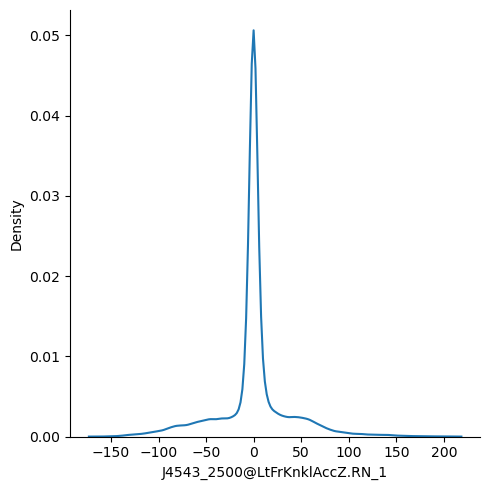

In [9]:
sns.displot(data=ab10_2500Hz, x="J4543_2500@LtFrKnklAccZ.RN_1", kind="kde")

### Distribution of the front left damper displacements

The mean value is close to 60mm

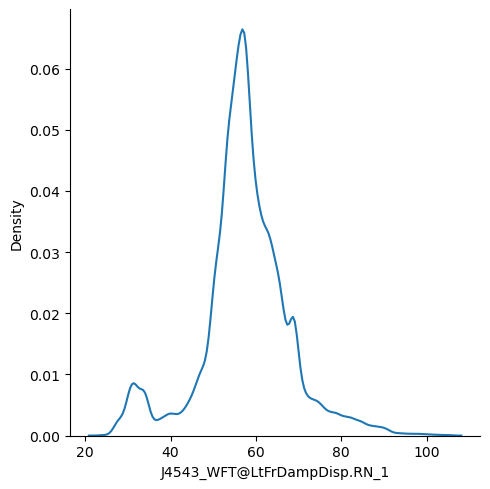

In [10]:
sns.displot(data=ab10_1000Hz, x="J4543_WFT@LtFrDampDisp.RN_1", kind="kde")

### Distribution of the front spindle FZ

The mean value is close to 7500N

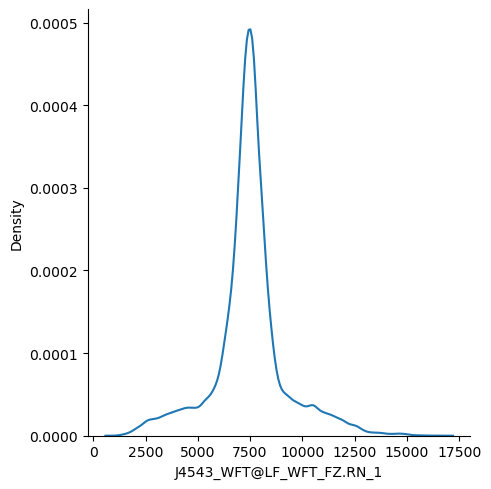

In [11]:
sns.displot(data=ab10_1000Hz, x="J4543_WFT@LF_WFT_FZ.RN_1", kind="kde")

### Time series of spindle FZ

<Axes: xlabel='time (s)', ylabel='J4543_WFT@LF_WFT_FZ.RN_1'>

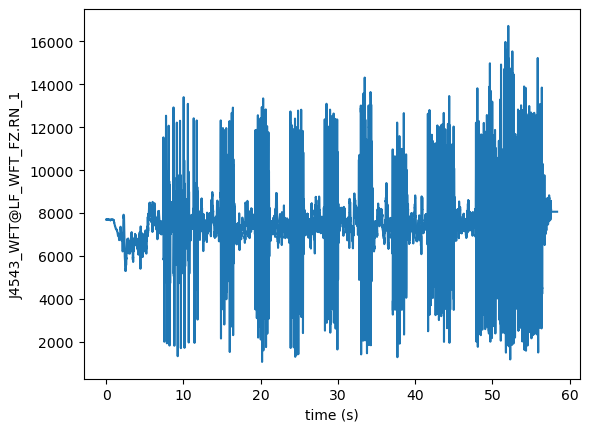

In [12]:
sns.lineplot(data=ab10_1000Hz, x="time (s)",y="J4543_WFT@LF_WFT_FZ.RN_1")

### Feature Engineering

Some Feature engineering is needed since the force in Z direction at the spindle is function of the acceleration (inertia/acceleration), the length of the spring ( damper displacement) and the velocity of the damper ( viscous force). For the last one, the speed must be calculated from the displacement.

In [13]:
# Here we calculate the damper velocity using the damper displacement
ab10_1000Hz["Damper_vel_LF"]=np.gradient(ab10_1000Hz["J4543_WFT@LtFrDampDisp.RN_1"],0.0004)
ab10_1000Hz["Damper_vel_RF"]=np.gradient(ab10_1000Hz["J4543_WFT@RtFrDampDisp.RN_1"],0.0004)
ab10_1000Hz["Damper_vel_LR"]=np.gradient(ab10_1000Hz["J4543_WFT@LtRrDampDisp.RN_1"],0.0004)
ab10_1000Hz["Damper_vel_RR"]=np.gradient(ab10_1000Hz["J4543_WFT@RtRrDampDisp.RN_1"],0.0004)

### Data merging, bring all 3 dataframes into one

In [14]:
ab10_t=ab10_1000Hz[:144000].merge(ab10_500Hz[:144000],how="outer",left_on="time (s)",right_on="time (s)")
ab10=ab10_t.merge(ab10_2500Hz[:144000],how="outer",left_on="time (s)",right_on="time (s)")

### Correlation between the variables

FL FZ that we will be focussing on has an in phse correlation with FL MX but MX is an output. There is also an out of phase correlation with FL MZ. The moments MX and MZ are correlated to the forces, once the forces are calculated, the results can be used to calculate the two moments.

All MY are correlated, the two front highly correlated between them same for the rear. This is because those moments are linked to the torque from the engines and the breakings. Part of the breaking is from the regen meaning negative torque.

<Axes: >

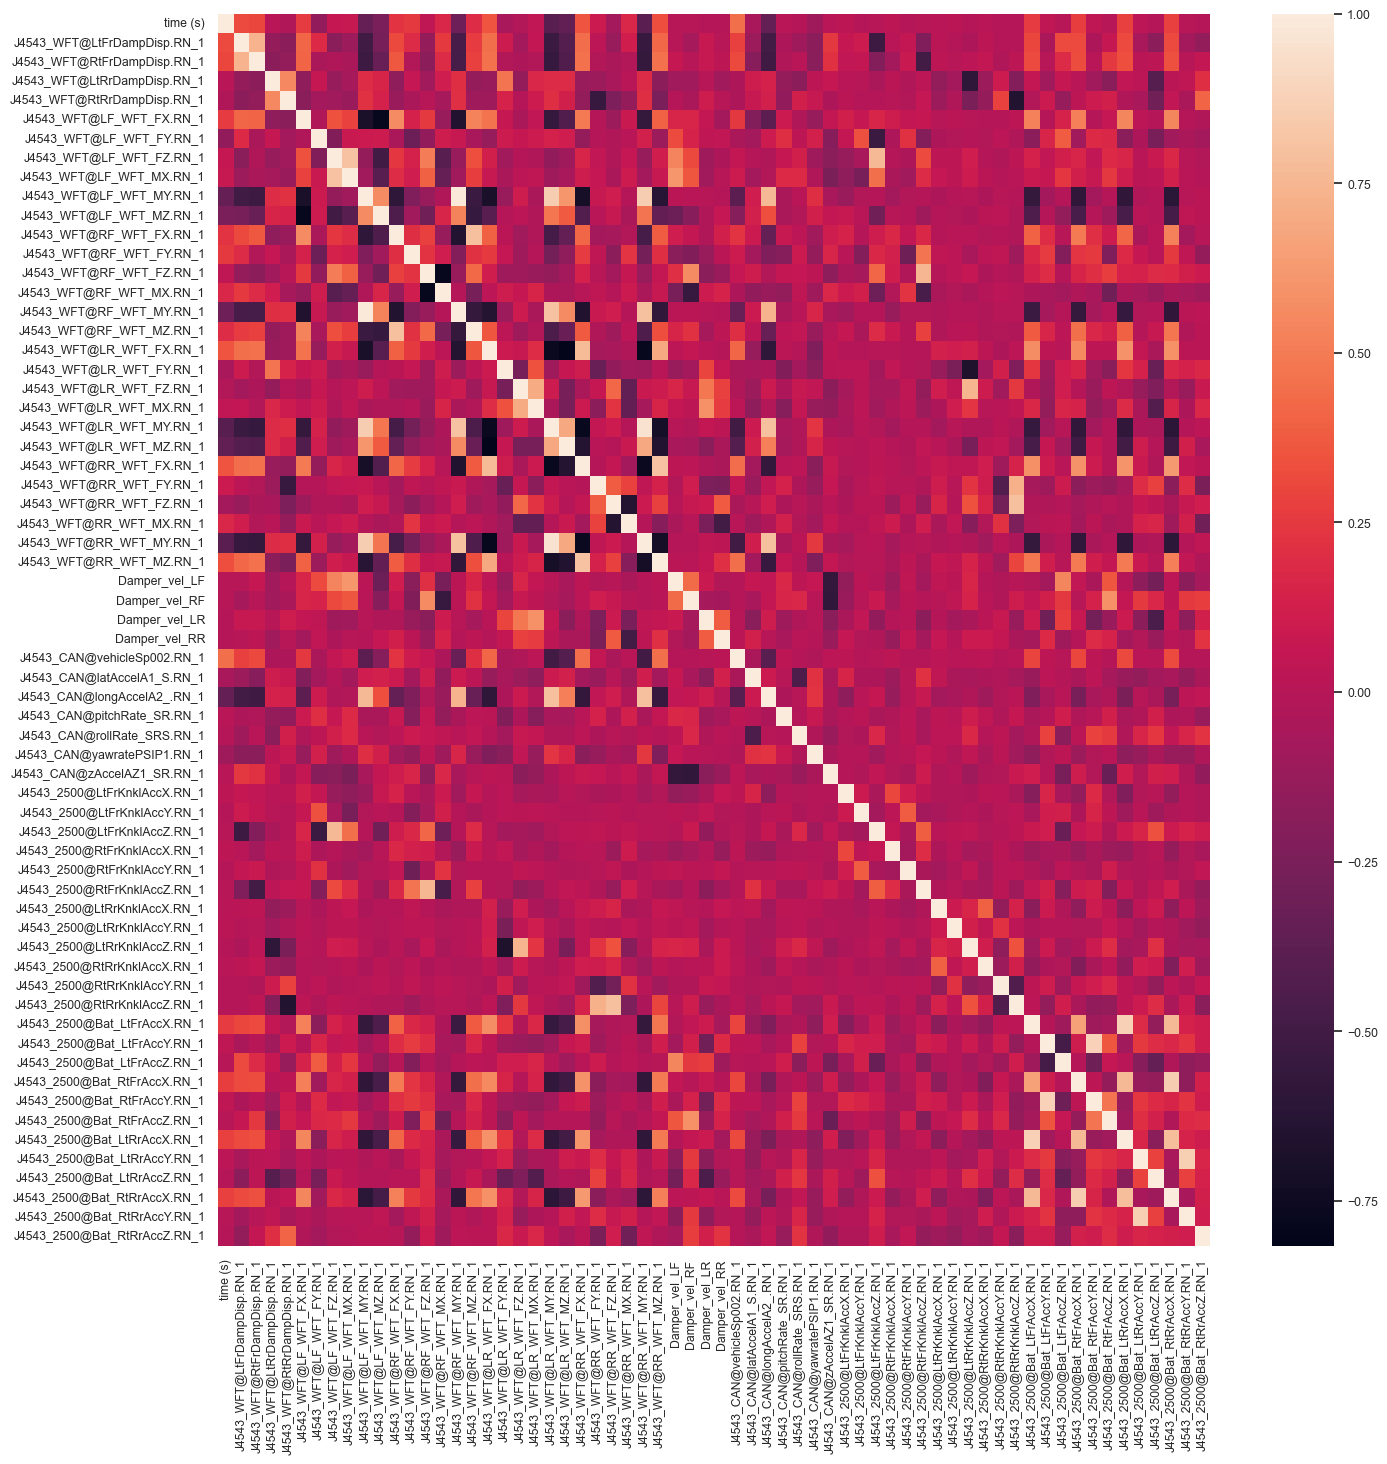

In [15]:
sns.set(rc={'figure.figsize':(16,16)},font_scale=0.8)
sns.heatmap(ab10.corr())

### Here we drop the output features

In [16]:
drop_list=["J4543_WFT@LF_WFT_FX.RN_1","J4543_WFT@LF_WFT_FY.RN_1","J4543_WFT@LF_WFT_FZ.RN_1"
           ,"J4543_WFT@LF_WFT_MX.RN_1","J4543_WFT@LF_WFT_MY.RN_1","J4543_WFT@LF_WFT_MZ.RN_1"
           ,"J4543_WFT@RF_WFT_FX.RN_1","J4543_WFT@RF_WFT_FY.RN_1","J4543_WFT@RF_WFT_FZ.RN_1"
           ,"J4543_WFT@RF_WFT_MX.RN_1","J4543_WFT@RF_WFT_MY.RN_1","J4543_WFT@RF_WFT_MZ.RN_1"
           ,"J4543_WFT@LR_WFT_FX.RN_1","J4543_WFT@LR_WFT_FY.RN_1","J4543_WFT@LR_WFT_FZ.RN_1"
           ,"J4543_WFT@LR_WFT_MX.RN_1","J4543_WFT@LR_WFT_MY.RN_1","J4543_WFT@LR_WFT_MZ.RN_1"
           ,"J4543_WFT@RR_WFT_FX.RN_1","J4543_WFT@RR_WFT_FY.RN_1","J4543_WFT@RR_WFT_FZ.RN_1"
           ,"J4543_WFT@RR_WFT_MX.RN_1","J4543_WFT@RR_WFT_MY.RN_1","J4543_WFT@RR_WFT_MZ.RN_1"]
keep_list=ab10.drop(drop_list, axis = 1).columns

### What features should we keep for the front left FZ

```
From the results bellow, the first 3 features are choose:

-The FL Knuckle Z accelerations
-The FL Damper velocity
-The FL Damper displacements
```

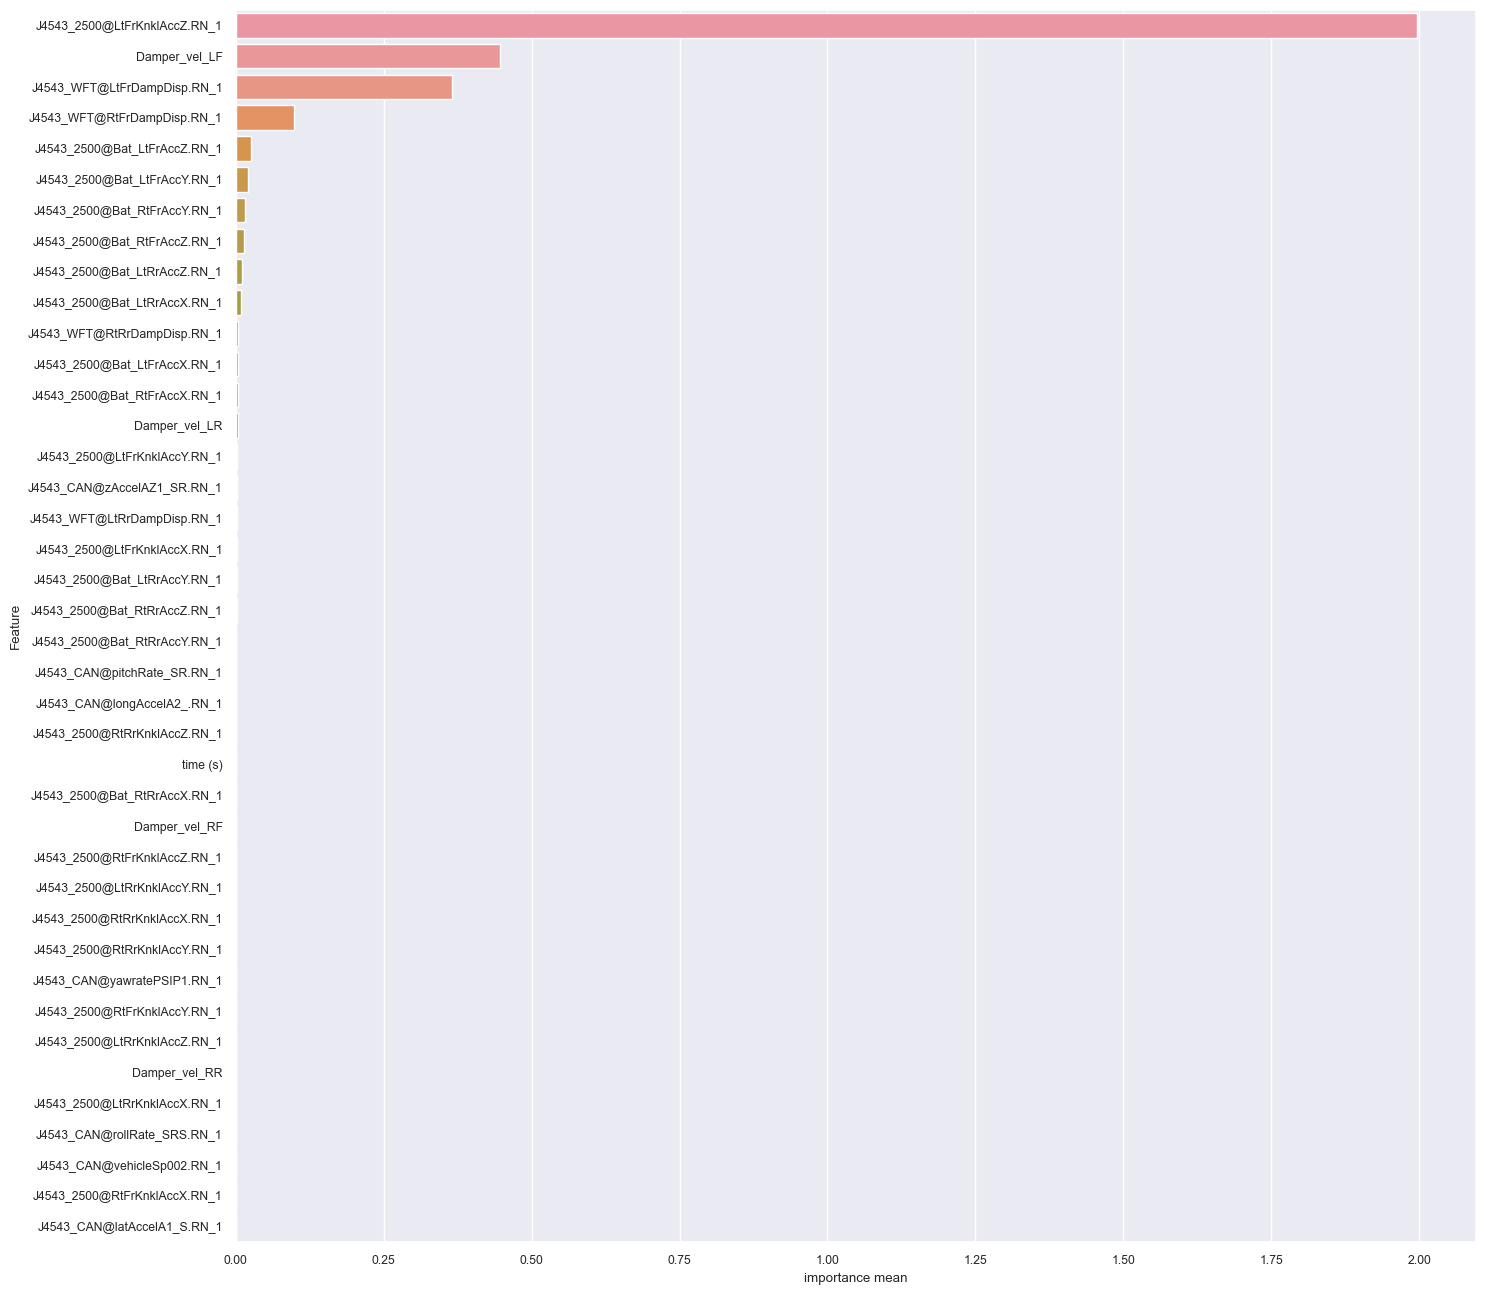

In [17]:
# Definition of the inputs and output
X = ab10.drop(drop_list, axis = 1)
y = ab10["J4543_WFT@LF_WFT_FZ.RN_1"]
# The data is splitted into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = .33)
# A linear regression instance is created and fitted
lr = LinearRegression().fit(X_train,y_train)
# Permutation importance is applied to the linear regression
r = permutation_importance(lr, X, y,
                            n_repeats=5,
                            random_state=42)
# The importance of the features is plotted
liste_f = []
imp_mean = []
for i in r.importances_mean.argsort()[::-1]:
    liste_f.append(X.columns[i])
    imp_mean.append(r.importances_mean[i])
d = {'Feature': liste_f, 'importance mean': imp_mean}
per_imp = pd.DataFrame(data=d)
sns.barplot(data=per_imp, x="importance mean", y="Feature")
plt.show()

### Keeping only the 3 features selected

In [18]:
X = ab10[["J4543_WFT@LtFrDampDisp.RN_1","Damper_vel_LF","J4543_2500@LtFrKnklAccZ.RN_1"]]
y = ab10["J4543_WFT@LF_WFT_FZ.RN_1"]
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

### Linear regression model

In [19]:
# Measure the duration of process
start_time = time.time()
lr = LinearRegression().fit(X_train,y_train)
end_time = time.time()
lr_time = end_time - start_time
lr_mse_training = mean_squared_error(y_train,lr.predict(X_train))
lr_mse_test = mean_squared_error(y_test,lr.predict(X_test))
lr_mse_test

169458.38661193915

### KNN best regression model

In [20]:
# 
knn_params = {'n_neighbors':[1,3,5,6,7,8,9,10], 'weights':['uniform','distance']
              , 'algorithm':['auto','ball_tree','kd_tree','brute']}
#
knn = KNeighborsRegressor()
#
knn_search = RandomizedSearchCV(knn, knn_params).fit(X_train,y_train)
#
knn_search.best_params_

{'weights': 'distance', 'n_neighbors': 9, 'algorithm': 'ball_tree'}

Measuring the best KNN model

In [21]:
start_time = time.time()
knn = KNeighborsRegressor(n_neighbors=9, weights='distance', algorithm='ball_tree').fit(X_train,y_train)
end_time = time.time()
knn_time = end_time - start_time
knn_mse_training = mean_squared_error(y_train,knn.predict(X_train))
knn_mse_test = mean_squared_error(y_test,knn.predict(X_test))
knn_mse_test

60103.10299190869

### Decision Tree best regression model

In [22]:
#
dt_params = {'max_depth':[20,21,22], 'criterion':['friedman_mse', 'poisson']
             , 'splitter':['best','random'], 'min_samples_split':[11,12,13]}
#
dt = DecisionTreeRegressor()
#
dt_best = RandomizedSearchCV(dt, dt_params).fit(X_train,y_train)
#
dt_best.best_params_

{'splitter': 'random',
 'min_samples_split': 13,
 'max_depth': 21,
 'criterion': 'friedman_mse'}

Measuring the best Decision Tree model

In [23]:
start_time = time.time()
DT = DecisionTreeRegressor(max_depth=22,splitter='random',min_samples_split=12).fit(X_train,y_train)
end_time = time.time()
dt_time = end_time - start_time
DT_mse_training = mean_squared_error(y_train,DT.predict(X_train))
DT_mse_test = mean_squared_error(y_test,DT.predict(X_test))
DT_mse_test

90596.92424051571

### AdaBoostRegressor model

In [24]:
#
adb_params = {'learning_rate':[0.1,0.5,1], 'loss':['linear', 'square', 'exponential']}
#
adb = AdaBoostRegressor()
#
adb_best = RandomizedSearchCV(adb, adb_params).fit(X_train,y_train)
#
adb_best.best_params_

{'loss': 'exponential', 'learning_rate': 1}

Measuring the best Adaboost model

In [25]:
start_time = time.time()
adb = AdaBoostRegressor(loss='linear',learning_rate=1).fit(X_train,y_train)
end_time = time.time()
adb_time = end_time - start_time
adb_mse_training = mean_squared_error(y_train,adb.predict(X_train))
adb_mse_test = mean_squared_error(y_test,adb.predict(X_test))
adb_mse_test

350858.77644788777

### RandomForestRegressor model

In [26]:
##
#rf_params = {'max_depth':[15,20,25], 'criterion':['friedman_mse', 'poisson'], 'min_samples_split':[11,12,13]}
##
#rf = RandomForestRegressor()
##
#rf_best = RandomizedSearchCV(rf, rf_params).fit(X_train,y_train)
##
#rf_best.best_params_

### SVM regression model

In [27]:
# This model takes too long to run on my computer
#start_time = time.time()
#svr = SVR().fit(X_train, y_train)
#end_time = time.time()
#svr_time = end_time - start_time
#SVR_mse_training = mean_squared_error(y_train,svr.predict(X_train))
#SVR_mse_test = mean_squared_error(y_test,svr.predict(X_test))
#SVR_mse_test

### Neural Network model

In [28]:
NN = Sequential()

NN.add(Dense(10,activation='relu'))
NN.add(Dense(5,activation='sigmoid'))
NN.add(Dense(3,activation='relu'))
NN.add(Dense(3,activation='relu'))
NN.add(Dense(1))

NN.compile(optimizer='adam',loss='mse')
start_time = time.time()
NN.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=210, epochs=100)

Epoch 1/100
480/480 [==============================] - 3s 5ms/step - loss: 58863092.0000 - val_loss: 58704948.0000
Epoch 2/100
480/480 [==============================] - 2s 4ms/step - loss: 58519260.0000 - val_loss: 58176792.0000
Epoch 3/100
480/480 [==============================] - 2s 4ms/step - loss: 57748460.0000 - val_loss: 57139772.0000
Epoch 4/100
480/480 [==============================] - 2s 4ms/step - loss: 56413148.0000 - val_loss: 55495752.0000
Epoch 5/100
480/480 [==============================] - 2s 4ms/step - loss: 54450296.0000 - val_loss: 53213356.0000
Epoch 6/100
480/480 [==============================] - 2s 4ms/step - loss: 51851712.0000 - val_loss: 50304928.0000
Epoch 7/100
480/480 [==============================] - 2s 4ms/step - loss: 48649088.0000 - val_loss: 46819848.0000
Epoch 8/100
480/480 [==============================] - 2s 4ms/step - loss: 44905820.0000 - val_loss: 42835536.0000
Epoch 9/100
480/480 [==============================] - 2s 4ms/step - loss: 40709

480/480 [==============================] - 2s 4ms/step - loss: 87782.3828 - val_loss: 87893.8516
Epoch 75/100
480/480 [==============================] - 2s 4ms/step - loss: 87705.1953 - val_loss: 87186.6172
Epoch 76/100
480/480 [==============================] - 2s 4ms/step - loss: 87646.6562 - val_loss: 87578.5234
Epoch 77/100
480/480 [==============================] - 2s 4ms/step - loss: 87472.3438 - val_loss: 87863.9375
Epoch 78/100
480/480 [==============================] - 2s 4ms/step - loss: 87484.8516 - val_loss: 87118.5156
Epoch 79/100
480/480 [==============================] - 2s 4ms/step - loss: 87409.6250 - val_loss: 87117.9297
Epoch 80/100
480/480 [==============================] - 2s 4ms/step - loss: 87387.6094 - val_loss: 87695.0156
Epoch 81/100
480/480 [==============================] - 2s 4ms/step - loss: 87316.5625 - val_loss: 86760.7969
Epoch 82/100
480/480 [==============================] - 2s 4ms/step - loss: 87232.5703 - val_loss: 87723.4219
Epoch 83/100
480/480 [=

In [29]:
end_time = time.time()
nn_time = end_time - start_time

In [30]:
NN_mse_training = mean_squared_error(y_train,NN.predict(X_train))
NN_mse_test = mean_squared_error(y_test,NN.predict(X_test))
NN_mse_test

1350/1350 [==============================] - 3s 2ms/step


86580.87509415376

In [31]:
models = ['Linear Regression', 'KNN Regression', 'Decision Tree Regression', 'AdaBoost Regression', 'Neural Network']
durations = [lr_time, knn_time, dt_time, adb_time, nn_time]
training_mse = [lr_mse_training, knn_mse_training, DT_mse_training, adb_mse_training, NN_mse_training]
test_mse = [lr_mse_test, knn_mse_test, DT_mse_test, adb_mse_test, NN_mse_test]
d = {'Model': models, 'run duration': durations, 'Training MSE': training_mse, 'Test MSE': test_mse}
m_results = pd.DataFrame(data=d)

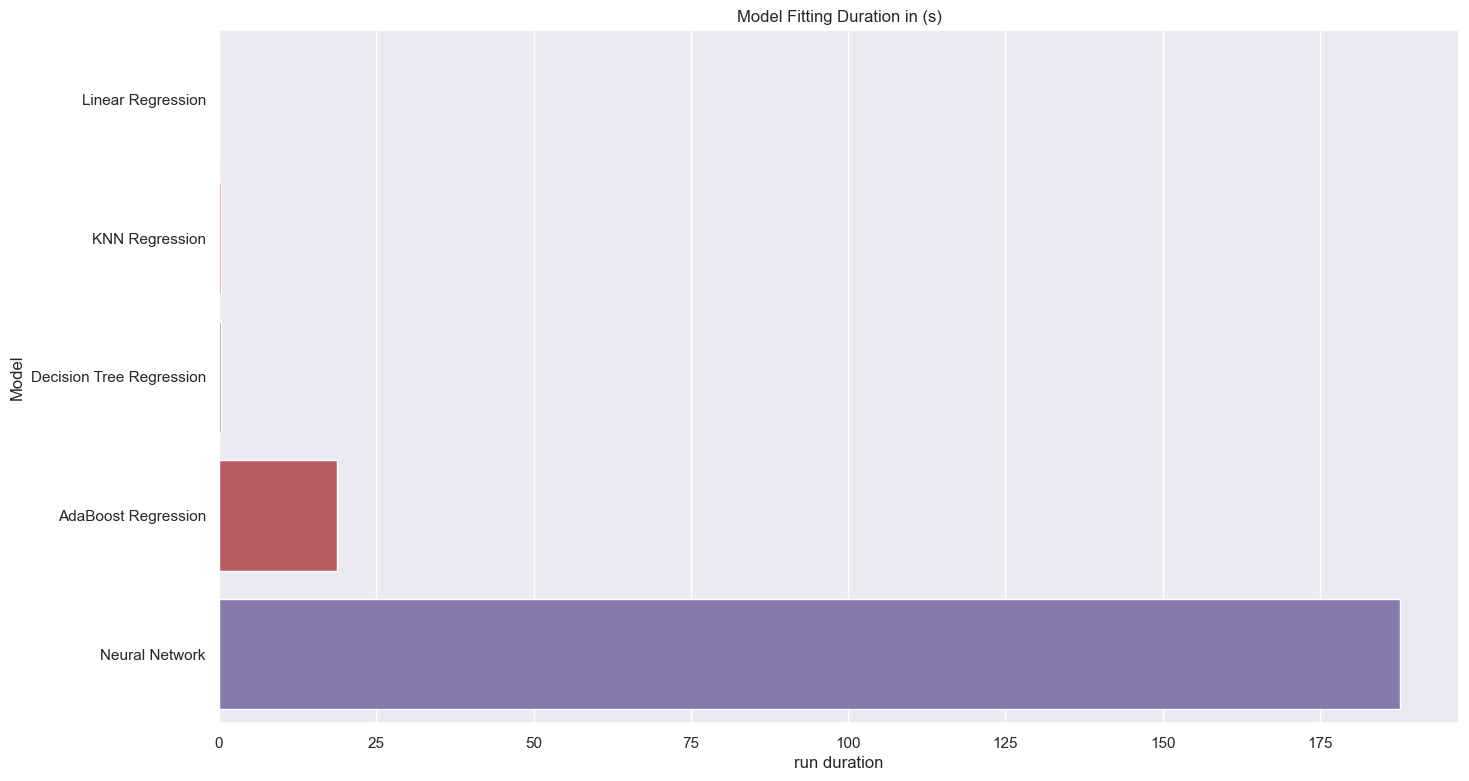

In [32]:
sns.set(rc={'figure.figsize':(16,9)},font_scale=1)
ax = sns.barplot(data=m_results, x="run duration", y="Model")
ax.set_title('Model Fitting Duration in (s)')
plt.show()

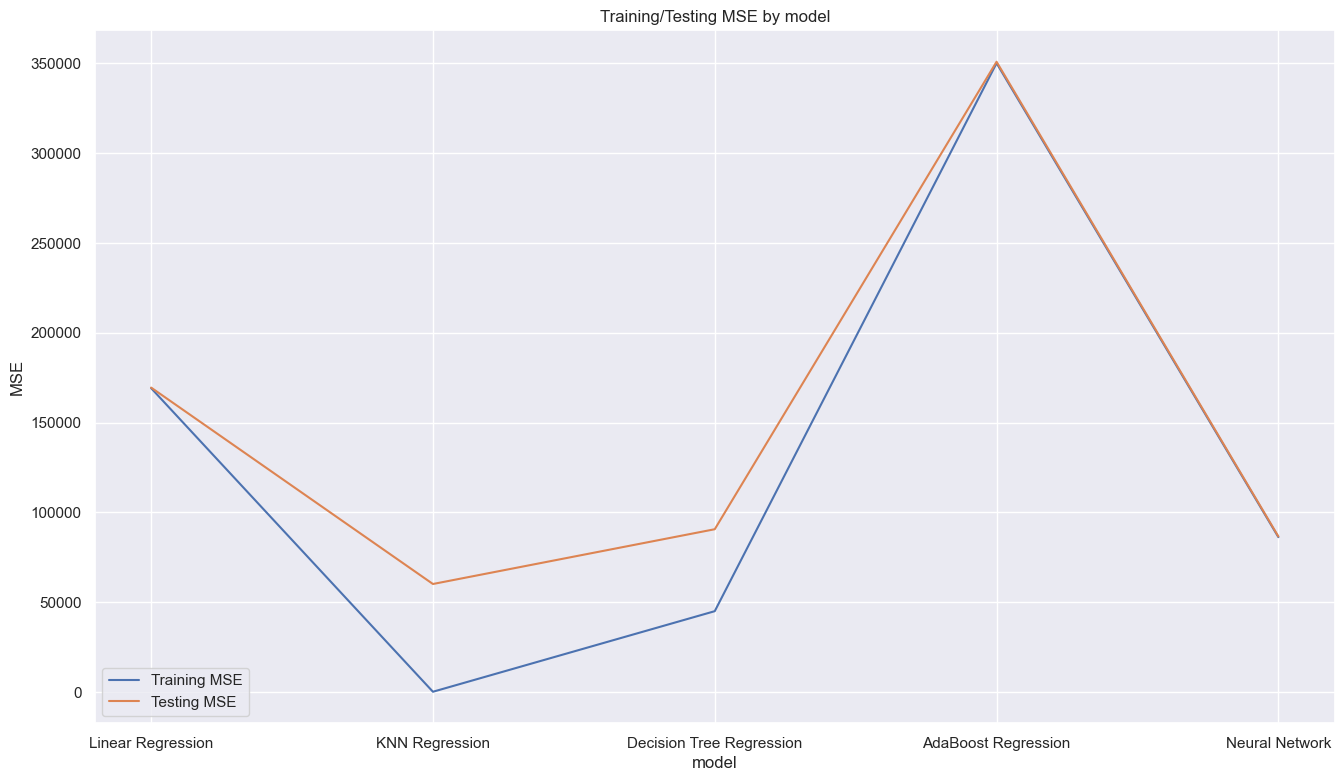

In [33]:
plt.plot(models, training_mse, label = "Training MSE")
plt.plot(models, test_mse, label = "Testing MSE")
plt.xlabel('model')
plt.ylabel('MSE')
leg = plt.legend(loc='lower left')
plt.title("Training/Testing MSE by model")
plt.show()

### What's the best model

The best model is KNN followed by the Neural Network. The Neural Network takes long to run and the results depend on the computer used. In some computers the Neural Network performs better than the KNN.

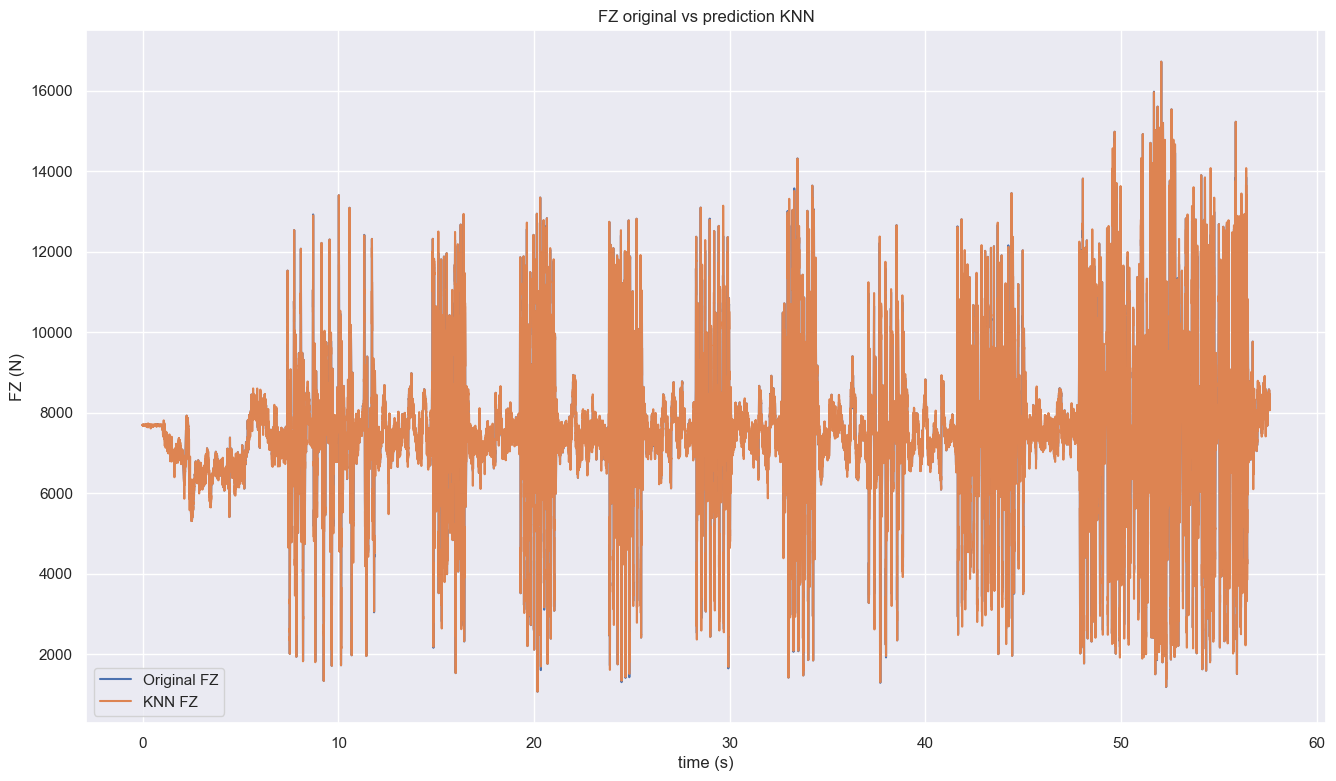

In [34]:
plt.plot(ab10["time (s)"], ab10["J4543_WFT@LF_WFT_FZ.RN_1"], label = "Original FZ")
plt.plot(ab10["time (s)"], knn.predict(X), label = "KNN FZ")
plt.xlabel('time (s)')
plt.ylabel('FZ (N)')
leg = plt.legend(loc='lower left')
plt.title("FZ original vs prediction KNN")
plt.show()

4500/4500 [==============================] - 10s 2ms/step


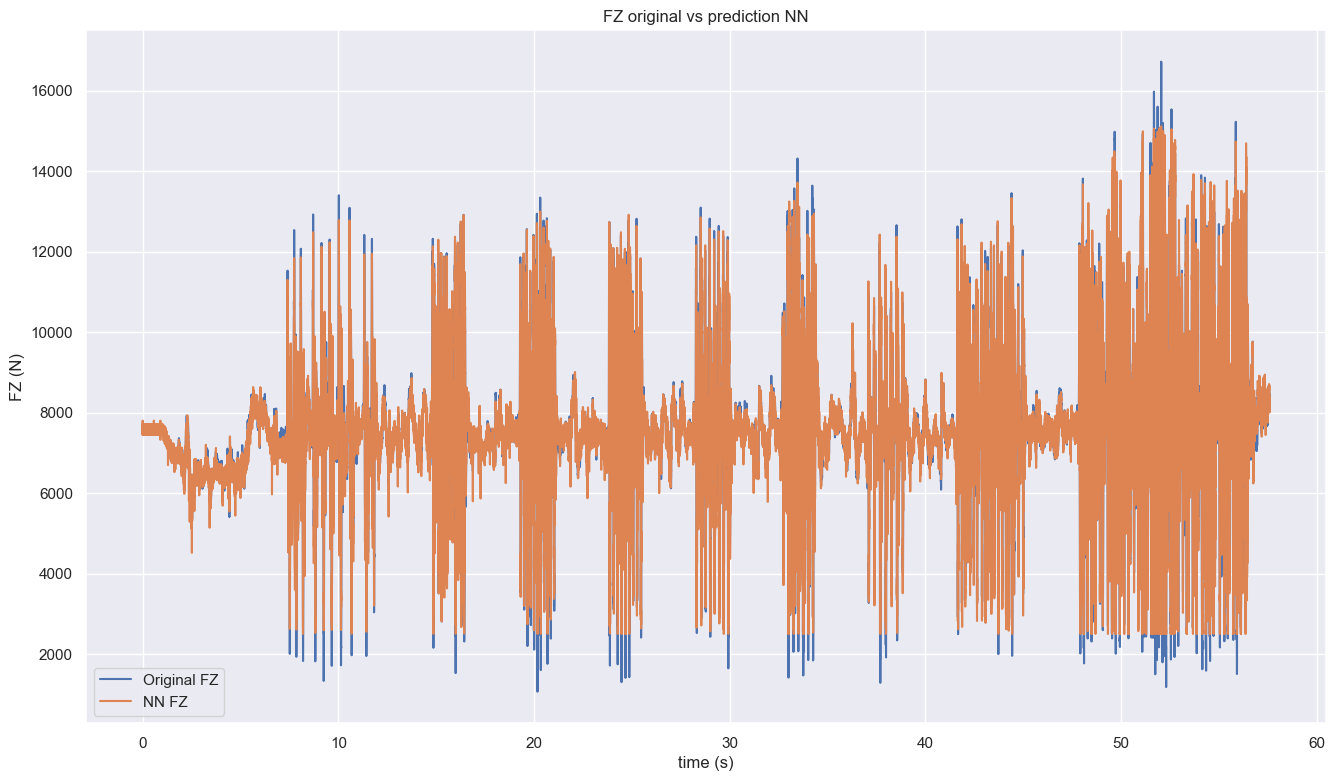

In [35]:
nn_predict = NN.predict(X)
plt.plot(ab10["time (s)"], ab10["J4543_WFT@LF_WFT_FZ.RN_1"], label = "Original FZ")
plt.plot(ab10["time (s)"], nn_predict, label = "NN FZ")
plt.xlabel('time (s)')
plt.ylabel('FZ (N)')
leg = plt.legend(loc='lower left')
plt.title("FZ original vs prediction NN")
plt.show()

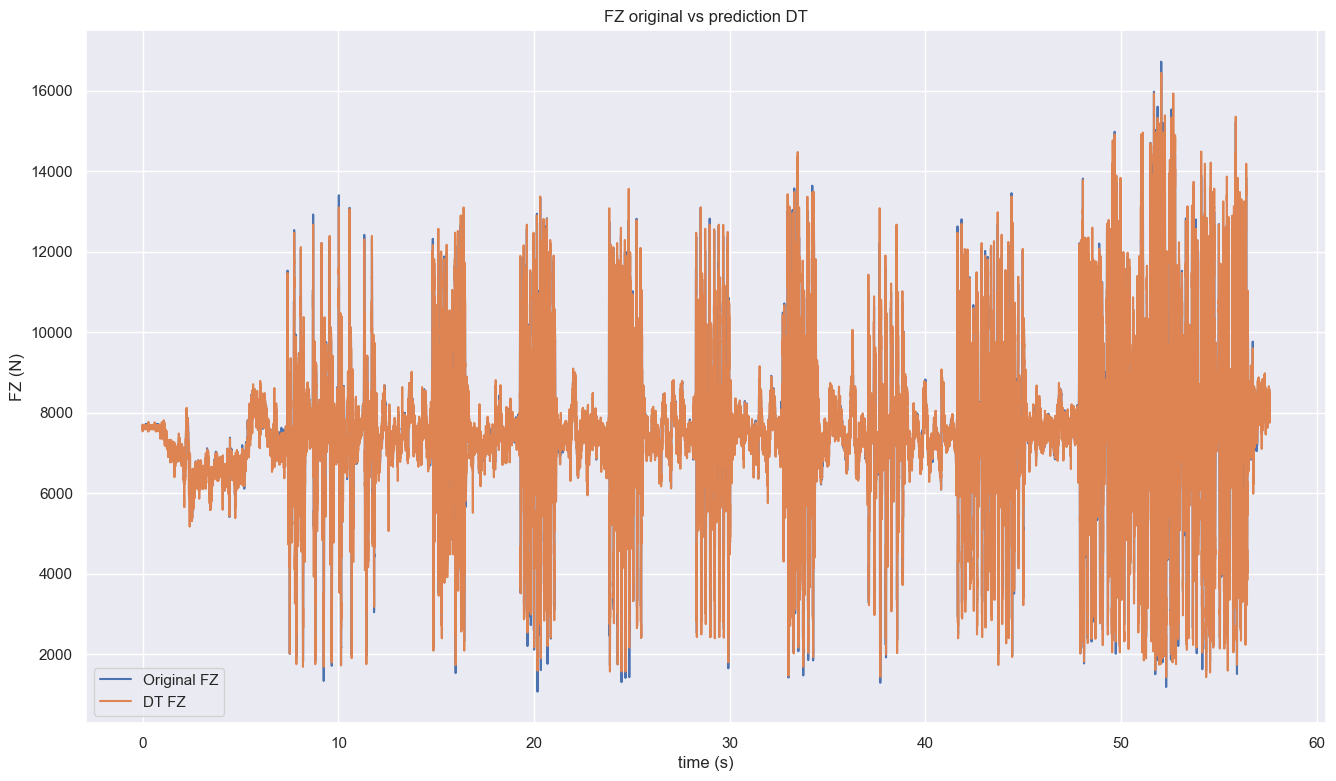

In [36]:
plt.plot(ab10["time (s)"], ab10["J4543_WFT@LF_WFT_FZ.RN_1"], label = "Original FZ")
plt.plot(ab10["time (s)"], DT.predict(X), label = "DT FZ")
plt.xlabel('time (s)')
plt.ylabel('FZ (N)')
leg = plt.legend(loc='lower left')
plt.title("FZ original vs prediction DT")
plt.show()

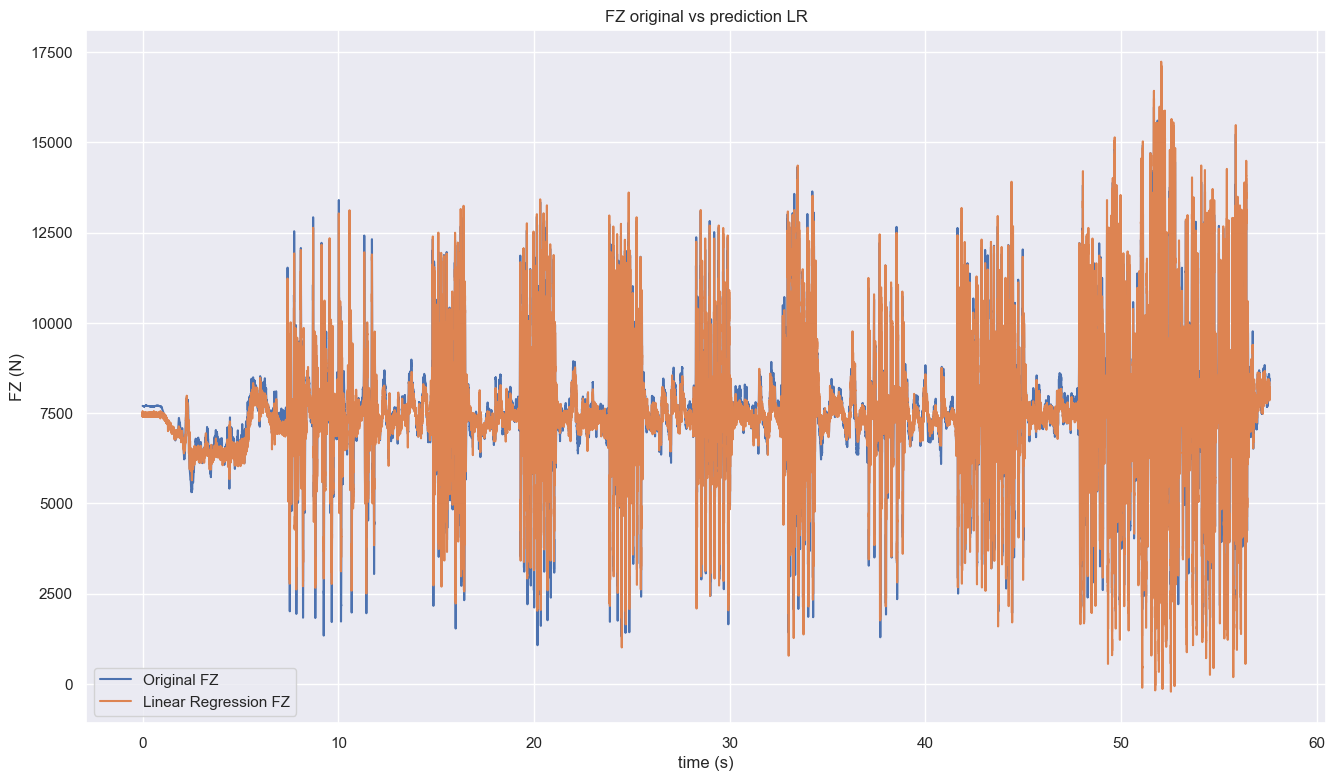

In [37]:
plt.plot(ab10["time (s)"], ab10["J4543_WFT@LF_WFT_FZ.RN_1"], label = "Original FZ")
plt.plot(ab10["time (s)"], lr.predict(X), label = "Linear Regression FZ")
plt.xlabel('time (s)')
plt.ylabel('FZ (N)')
leg = plt.legend(loc='lower left')
plt.title("FZ original vs prediction LR")
plt.show()

### Conclusions

Four of the five models used performed very well. With KNN been the best of four with the Neural Network one being too noisy afilter can be used on the output.
The risk of overfitting is high for the KNN model followed by the Decision Tree model.
The simple linear regression has very good results as well even if there is a little offset observed with zero risk of overfitting. That is a model to always keep in mind

### Next steps

Not included in this study, is the possibility to add different vent type a WOT (Wide Open Throtle), a hard braking... The signature of some events or maneuver are completly different. It will be a good thing to include the maximum number of events possible.

More broadly, data from simulation can help with create a model that take many charasteristic of a car, ad example the mass, the center of mass, the shock assembly specifics  and many others and output loads rirectly for differents components.